# Load Data from Files

In [1]:
import xml.etree.ElementTree as ET
import json
import pandas as pd
import numpy as np
from pprint import pprint

file_dir = "./data/AviationData.xml"
narr_dir = "./data/NarrativeData_"

tree = ET.parse(file_dir)
root = tree.getroot()

In [2]:
### count for each types of nodes in XML
tag_count_dict = dict()
for node in tree.iter():
    if node.tag not in tag_count_dict:
        tag_count_dict[node.tag] = 0
    tag_count_dict[node.tag] += 1
all_count = tag_count_dict["{http://www.ntsb.gov}ROW"]
pprint(tag_count_dict)

{'{http://www.ntsb.gov}DATA': 1,
 '{http://www.ntsb.gov}ROW': 77257,
 '{http://www.ntsb.gov}ROWS': 1}


The structure of this XML dataset is easy to parse. We only need the attribute within "ROW" tag. There are 77257 events ("ROW" tag) in the XML file.

In [3]:
### count for event in JSON
narr_name = ["000"]
narr_name.extend(range(499, 71000, 500))
narr_name.append(999999)
narr_name = list(map(lambda x: str(x)+".json", narr_name))

report_count = 0
narr_count = 0
cause_count = 0
missing_count = 0

for name in narr_name:
    with open(narr_dir + name) as f:
        narr_data = json.load(f)["data"]   # a list of events
        for event in narr_data:
            report_count += int(event["EventId"] != "")
            narr_count += int(event["narrative"] != "")
            cause_count += int(event["probable_cause"] != "")
            missing_count += int(event["narrative"] == "" and event["probable_cause"] == "")

# short summary for JSON files
print("Count for -\nEvent:\t%d\nNarr:\t%d\nCause:\t%d\nMiss:\t%d" %
      (report_count, narr_count, cause_count, missing_count))

Count for -
Event:	76133
Narr:	75905
Cause:	49789
Miss:	227


Notice that the event count in JSON file is 1124 less than the number of "ROW"s in the XML file. However this does not necessarily means 1124 missing entries in the JSON file. In fact, the EventId is not a unique ID in the XML file in this senario. Some event has the same EventId but they are differnt entries with differnt "AccidentNumber". Thus when parsing the XML file later, I choose to use AccidentNumber as the unique id and create a dictionary called eid_anum_dict to store the relations between EventId and AccidentNumber.

There are 76133 Event in these JSON files. 228 (0.30%) of them has a empty string for "narrative" and 26344 (34.60%) of them has a empty string for "probable_cause". 227 (0.30%) of them has both an empty string for "narrative" and "probable_cause".

These 2 kinds of data are completely corresponding, no more no less. Next we start parsing these 2 kinds of data.

In [4]:
### iterate through XML to add information
accident_dict = dict()  # AccidentNumber as unique key
eid_anum_dict = dict()  # use EventId to get AccidentNumber
for node in tree.iter(tag="{http://www.ntsb.gov}ROW"):
    anum = node.attrib["AccidentNumber"]
    eid = node.attrib["EventId"]
    accident_dict[anum] = node.attrib
    if eid not in eid_anum_dict:
        eid_anum_dict[eid] = list()
    eid_anum_dict[eid].append(anum)

In [5]:
df_accident = pd.DataFrame.from_dict(accident_dict, orient='index')
df_accident.loc[["WPR15LA253A","WPR15LA253B","WPR15FA243A","WPR15FA243B"],:] # EventId is not unique

EventId InvestigationType AccidentNumber   EventDate  \
WPR15LA253A  20150831X30510          Accident    WPR15LA253A  08/28/2015   
WPR15LA253B  20150831X30510          Accident    WPR15LA253B  08/28/2015   
WPR15FA243A  20150816X60452          Accident    WPR15FA243A  08/16/2015   
WPR15FA243B  20150816X60452          Accident    WPR15FA243B  08/16/2015   

                  Location        Country   Latitude    Longitude AirportCode  \
WPR15LA253A  Las Vegas, NV  United States  36.099444  -115.162500         LAS   
WPR15LA253B  Las Vegas, NV  United States  36.099444  -115.162500         LAS   
WPR15FA243A  San Diego, CA  United States  32.578611  -116.957778         SDM   
WPR15FA243B  San Diego, CA  United States  32.578611  -116.957778         SDM   

                        AirportName       ...       PurposeOfFlight  \
WPR15LA253A  McCarran International       ...              Business   
WPR15LA253B  McCarran International       ...              Business   
WPR15FA243A        BROWN FIELD MUNI       ...              Personal   
WPR15FA243B        BROWN FIELD MUNI       ...        Other Work Use   

            AirCarrier TotalFatalInjuries TotalSeriousInjuries  \
WPR15LA253A                                                      
WPR15LA253B                                                      
WPR15FA243A                             5                        
WPR15FA243B                             5                        

            TotalMinorInjuries TotalUninjured WeatherCondition  \
WPR15LA253A                                 5              VMC   
WPR15LA253B                                 5              VMC   
WPR15FA243A                                                VMC   
WPR15FA243B                                                VMC   

            BroadPhaseOfFlight ReportStatus PublicationDate  
WPR15LA253A           STANDING  Preliminary      09/03/2015  
WPR15LA253B           STANDING  Preliminary      09/03/2015  
WPR15FA243A           APPROACH  Preliminary      08/26/2015  
WPR15FA243B           APPROACH  Preliminary      08/26/2015  

[4 rows x 31 columns]

In [6]:
### iterate through JSON to add information
narr_dict = dict()
for name in narr_name:
    with open(narr_dir + name) as f:
        narr_data = json.load(f)["data"]   # a list of events
        for event in narr_data:
            eid = event["EventId"]
            ''' # check for duplicate - NO duplicate
            if eid in narr_dict:
                print("weird:\t", eid)
            '''
            narr_dict[eid] = event

I created 3 dictionaries to store all the information. One is called accident_dict, used to store the structured information parsed from XML file. One is called narr_dict, used to store all the raw text parsed from the JSON file. Also I included a dictionary called eid_anum_dict, used to store the relations between EventId and AccidentNumber. In addition, I created a Pandas DataFrame called df_accident to store the structured data for later use.

# Topic Clustering with Cause Data

In [7]:
import string
import nltk
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

def preprocess(d=None, item="both", rm_stop=True, rm_digit=True,
               rm_punc=True, lower=True, stemming=True, freq_threshold=1):
    '''
    d               - dictionary used to store raw texts
    item            - use "narr" to process "narrative", use "cause" to process "probable_cause"
                      and use "both" to process both by concatenating them together
    rm_stop         - a flag indicating whether to remove stop words or not
    rm_digit        - a flag indicating whether to remove digits or not
    rm_punc         - a flag indicating whether to remove punctuations or not
    lower           - a flag indicating whether to lower all the texts or not
    stemming        - a flag indicating whether to stemming all the words or not
    freq_threshold  - set the threshold of token frequncy to trim the corpus
    -----------------------------------------------------------------------
    return:     documents   - a list of lists of tokens 
                eventID     - a list of EventId
                frequency   - a Counter store the counts for each token
    '''
    
    assert type(d) == dict and item in ["narr", "cause", "both"], "Input Error"
    documents = list()
    eventID = list()
    frequency = Counter()
    
    # which item to use
    if item == "narr":
        items = ["narrative", None]
    elif item == "cause":
        items = ["probable_cause", None]
    else:
        items = ["narrative", "probable_cause"]
    
    # what to remove
    rm_digit_list = ["", string.digits]
    rm_punc_list = ["", string.punctuation]
    rm_str = rm_digit_list[int(rm_digit)] + rm_punc_list[int(rm_punc)]
    
    # stopwords
    stoplist = set(stopwords.words('english')) if rm_stop else []
    
    for key, value in narr_dict.items():
        sent = value.get(str(items[0]), "") + value.get(str(items[1]), "")
        if sent != "":  # remove empty documents
            sent = sent.translate(str.maketrans('', '', rm_str))
            if lower:
                sent = sent.lower()
            if stemming:
                ps = PorterStemmer()
                text = [ps.stem(word) for word in sent.split() if word not in stoplist]
            else:
                text = [word for word in sent.split() if word not in stoplist]
            documents.append(text)
            eventID.append(key)
            frequency.update(text)
    
    # remove unfrequent words
    documents = [[word for word in doc if frequency[word] > freq_threshold] for doc in documents]
    
    return documents, eventID, frequency

## Using LSI to find the number of possible topics

In [8]:
from sklearn.cluster import KMeans, DBSCAN
from pprint import pprint
from gensim import corpora
from gensim.models import lsimodel, ldamodel

In [9]:
### preprocess only probable_cause text
docs_cause, eventID_cause, freq_cause = preprocess(d = narr_dict, item="cause")

# create dictionary between tokens and counts
dict_cause = corpora.Dictionary(docs_cause)

# create corpus for each document
corpus_cause = [dict_cause.doc2bow(doc) for doc in docs_cause]

In [10]:
### Latent Semantic Analysis
# extract 10 LSI topics; use the default one-pass algorithm
lsi_cause = lsimodel.LsiModel(corpus=corpus_cause, id2word=dict_cause, num_topics=15)

In [11]:
lsi_cause.print_topics(15, num_words=10)

[(0,
  '0.547*"pilot" + 0.377*"failur" + 0.259*"factor" + 0.255*"land" + 0.233*"result" + 0.217*"maintain" + 0.186*"control" + 0.171*"accid" + 0.143*"loss" + 0.132*"engin"'),
 (1,
  '-0.452*"engin" + -0.385*"loss" + -0.370*"power" + -0.364*"fuel" + 0.248*"pilot" + 0.234*"maintain" + -0.193*"due" + -0.190*"result" + 0.163*"failur" + 0.132*"control"'),
 (2,
  '-0.815*"land" + 0.230*"fuel" + -0.216*"gear" + 0.171*"pilot" + 0.137*"condit" + 0.131*"flight" + -0.104*"result" + 0.089*"engin" + -0.084*"flare" + 0.080*"inadequ"'),
 (3,
  '-0.570*"failur" + 0.323*"pilot" + -0.316*"maintain" + -0.259*"control" + 0.249*"factor" + 0.185*"condit" + 0.184*"land" + -0.171*"engin" + 0.156*"inadequ" + 0.154*"improp"'),
 (4,
  '-0.581*"fuel" + 0.278*"factor" + 0.271*"condit" + -0.244*"result" + 0.220*"loss" + 0.203*"terrain" + 0.196*"reason" + 0.181*"undetermin" + 0.177*"engin" + -0.170*"pilot"'),
 (5,
  '-0.589*"control" + 0.450*"failur" + -0.251*"loss" + -0.228*"result" + 0.213*"factor" + -0.207*"direc

From the printed topics above, we can see the top contributive words of each topic. Notice LSI shares a similar idea with PCA to the main components of every topics. Changing the number of topics will not change the representation of each topic (like the first 3 main components for PCA using n=5 is the same as the first 3 main components using n=10), so I used as many as topics here trying to find the number of possible topics for later use.

Below shown the manually summarized main idea for each topic above.

0. pilot's failure + a little land

1. no engine loss + pilot's failure to maintain

2. fuel & gear but no land

3. not pilot' failure

4. not fuel

5. not control related

6. flight condition (no pilot)

7. results from other stuff (maybe airspeed)

8. flight

9. no terrain, no maintain

10. airplane accident with contributing factors

11. not inadeqate (maybe not pilot's fault)

12. not improper (maybe not pilot's fault)

13. not maintaining airspeed as contributing factor

14. terrain as contributing factor

From the above generative topics, we can find that most topics are overlapped. This is a natural result for NLP problem because of the noise and synonyms. However, this helps us narrow down the number of possbile topics. I find that most topics of probable_cause are talking about:

1. pilot's failure (maintain/control)

2. landing terrain condition

3. engine or gear loss

4. fuel problem

5. flight(weather) condition (wind)

6. airspeed related (but this may be caused by other factors)

Some more exploratory resutls are attached in the Appendix part. Next I will use LDA to further analyze the topics with the number of topics I choose by using LSI.

## LDA

In [12]:
def get_weights(method, model, corpus, n_docs=49789):
    '''
    get the normalized weights of each docuemnt
    -----------------------------------------------------
    method  - indicating the class of the model
    model   - model class returned by gensim.models
    corpus  - corpus of documents
    n_docs  - number of documents
    -----------------------------------------------------
    return
    "lda"   - return the topic weights for each document in a matrix form
    "tfidf" - return the tfidf value for each document for each words in a matrix form
    "lsi"   - return the topic weights for each document in a matrix form
    '''
    
    assert method in ["lda", "lsi", "tfidf"], "Input Method Error"
    
    if method == "lda":
        n_topics = model.num_topics
        topic_weights = np.zeros((n_docs, n_topics))
        for i in range(n_docs):
            weight_sum = np.sum(model.get_document_topics(corpus[i]), axis=0)[1]  # used to normalize topic weights
            for sparse in model.get_document_topics(corpus[i]):
                topic_weights[i, sparse[0]] = sparse[1] / weight_sum
        return topic_weights
    elif method == "tfidf":
        n_words = len(model.idfs)
        doc_tfidf = np.zeros((n_docs, n_words))
        for i in range(n_docs):
            for sparse in model[corpus[i]]:
                doc_tfidf[i, sparse[0]] = sparse[1]
        return doc_tfidf
    else:
        n_topics = model.num_topics
        topic_weights = np.zeros((n_docs, n_topics))
        for i in range(n_docs):
            weight_sum = np.sum(model[corpus[i]], axis=0)[1]  # used to normalize topic weights
            for sparse in model[corpus[i]]:
                topic_weights[i, sparse[0]] = sparse[1] / weight_sum
        return topic_weights
        pass

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

def plot_word_cloud(topic_weight, docs, word_counter, counting_method="avg"):
    '''
    plot the word cloud for all the words with given topic weights
    -----------------------------------------------------
    topic_weight    - topic weights for each documents
    docs            - all documents
    word_counter    - a list of word_counter for each topic
    counting_method - use "avg" to assume that each document has some probabilities for each topics
                    - use "max" to assume that each document only belongs to one topic
    -----------------------------------------------------
    no returns
    '''
    
    assert len(word_counter) == topic_weight.shape[1], "Wrong Input-Counter Shape"
    assert counting_method in ["avg", "max"], "Wrong Input Error"
    
    n_doc, n_topics = topic_weight.shape
    for i in range(n_doc):
        if docs[i] != []:
            doc = docs[i]
            for word in doc:
                if counting_method == "avg":
                    weight = topic_weight[i]
                    for j, counter in enumerate(word_counter):
                        counter[word] += weight[j]
                else:
                    max_j = topic_weight[i].argmax()
                    word_counter[max_j][word] += 1
    
    fig, axs = plt.subplots((n_topics+1)//2, 2, figsize=(15, 5*((n_topics+1)//2)))
    for k, ax in enumerate(axs.flatten()):
        wordcloud = WordCloud().generate_from_frequencies(word_counter[k])
        ax.imshow(wordcloud)
        ax.set_title("Topic %d"%k)
        ax.axis('off')
    plt.show()    

In [14]:
### Latent Dirichlet Allocation
# extract 8 LDA topics, using 1 pass and updating once every 1 chunk (10,000 documents)
lda_cause8 = ldamodel.LdaModel(corpus=corpus_cause, id2word=dict_cause, num_topics=8, update_every=1, passes=1,
                              decay=0.7, offset=50)

lda_cause8.show_topics()

[(0,
  '0.071*"land" + 0.053*"loss" + 0.040*"failur" + 0.040*"engin" + 0.036*"undetermin" + 0.035*"power" + 0.035*"control" + 0.035*"reason" + 0.030*"result" + 0.028*"pilot"'),
 (1,
  '0.071*"pilot" + 0.035*"factor" + 0.033*"failur" + 0.028*"condit" + 0.024*"accid" + 0.023*"flight" + 0.023*"maintain" + 0.021*"terrain" + 0.016*"contribut" + 0.016*"altitud"'),
 (2,
  '0.041*"pilot" + 0.039*"failur" + 0.030*"runway" + 0.030*"result" + 0.020*"control" + 0.020*"airplan" + 0.019*"maintain" + 0.018*"rotor" + 0.016*"collis" + 0.013*"factor"'),
 (3,
  '0.085*"pilot" + 0.055*"failur" + 0.044*"maintain" + 0.042*"land" + 0.035*"factor" + 0.029*"control" + 0.027*"result" + 0.021*"accid" + 0.019*"wind" + 0.018*"condit"'),
 (4,
  '0.033*"propel" + 0.019*"engin" + 0.018*"fatigu" + 0.018*"blade" + 0.017*"failur" + 0.011*"result" + 0.011*"turbin" + 0.010*"fractur" + 0.010*"loss" + 0.010*"separ"'),
 (5,
  '0.042*"determin" + 0.040*"could" + 0.027*"reason" + 0.027*"engin" + 0.026*"normal" + 0.026*"examin"

In [15]:
lda_cause8.get_document_topics(corpus_cause[0])

[(1, 0.22561502), (2, 0.7475618)]

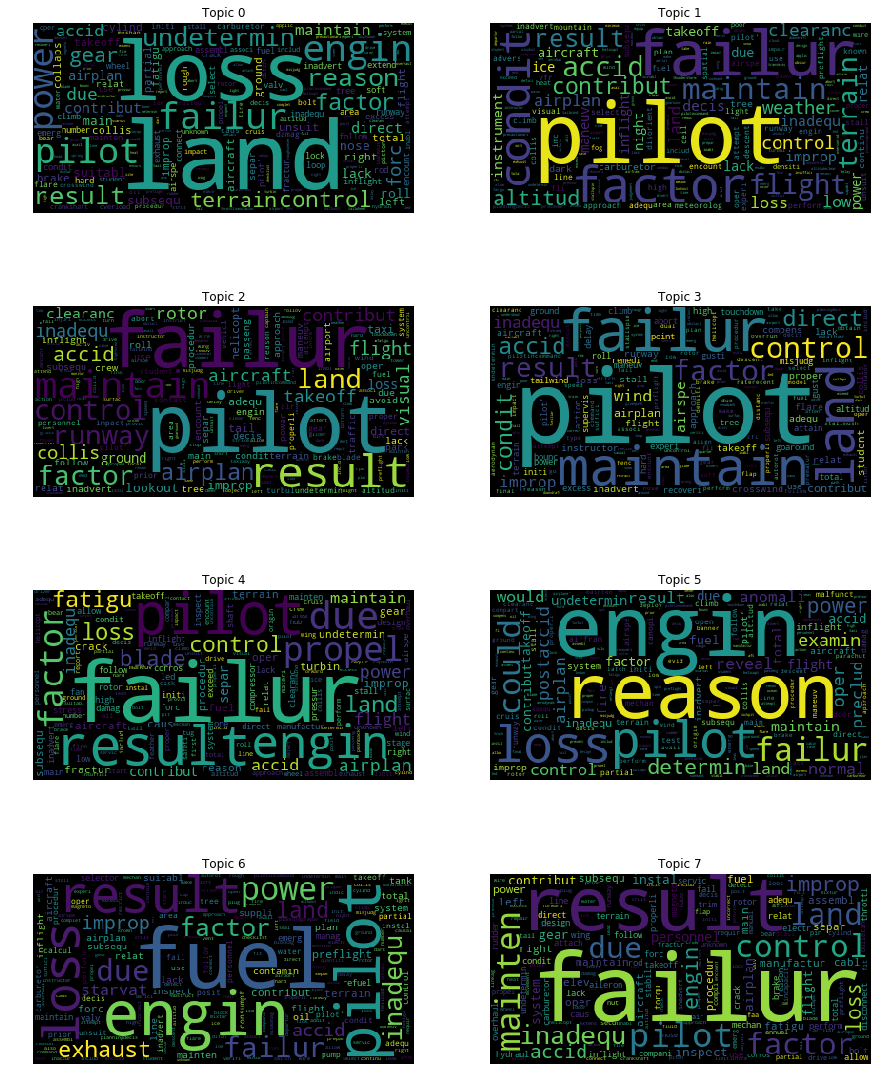

In [16]:
topic_weight_cause_lda8 = get_weights(method="lda", model=lda_cause8, corpus=corpus_cause)
word_counter8 = [Counter(),Counter(),Counter(),Counter(),Counter(),Counter(),Counter(),Counter()]

plot_word_cloud(topic_weight_cause_lda8, docs=docs_cause, word_counter=word_counter8, counting_method="avg")

LDA assum that each document has a latent distribution of topics, and each topic has a latent distribution of words. Usint LDA, we could assign each document a topic vector, representing its probability for belonging to each topic. 

However, LDA has the same problem as LSI. The topics they generated are overlapped with each other. It's hard to find a balance between LOD (level of detail) and generalization. This might come from the reason that this dataset is unbanlanced. Most event were generously caused by pilot's mistake, but they have differnt sub-reasons (like weather, landing, etc.). It's hard for LDA to catch this information if the dataset is not distinctive enough.

In order to capture the differnt sub-reasons, we need another algorithm which is more sensitive to those distinct words. Next I will implement TFIDF algorithm with clustering methods.

## TFIDF + KMeans

In [69]:
from gensim.models import TfidfModel

tfidf_cause = TfidfModel(corpus_cause)
tfidf_cause_vec = get_weights(method="tfidf", model=tfidf_cause, corpus=corpus_cause)
print(tfidf_cause_vec.shape)

(49789, 4649)


In [70]:
from sklearn.cluster import MiniBatchKMeans

minikmeans_model = MiniBatchKMeans(n_clusters=8, batch_size=10000, random_state=828)
minikmeans_cause = minikmeans_model.fit_transform(tfidf_cause_vec)
minikmeans_cause_OrderedCenter = minikmeans_model.cluster_centers_.argsort()[:,::-1]

In [71]:
print("--- Topic Keywords ---")
for i, topic in enumerate(minikmeans_cause_OrderedCenter):
    words = ""
    for word_i in topic[:10]:
        words += (dict_cause[word_i]+", ")
    print("Topic %d: " % i, words)

--- Topic Keywords ---
Topic 0:  gear, land, unsuit, mainten, main, engin, terrain, result, due, select, 
Topic 1:  undetermin, reason, power, engin, loss, forc, terrain, suitabl, partial, land, 
Topic 2:  condit, wind, compens, crosswind, weather, inadequ, gusti, instrument, flight, factor, 
Topic 3:  bounc, flare, recoveri, improp, land, student, hard, inadequ, pilot, instructor, 
Topic 4:  direct, control, maintain, roll, land, failur, airplan, crosswind, takeoff, pilot, 
Topic 5:  clearanc, failur, maintain, runway, pilot, proper, airplan, factor, flight, accid, 
Topic 6:  fuel, exhaust, engin, due, power, starvat, loss, preflight, inadequ, result, 
Topic 7:  airspe, stall, inadvert, adequ, maintain, altitud, result, failur, maneuv, aerodynam, 


In [72]:
print("--- Topic Counts ---")
for key in range(8):
    print("Topic %d: " % key, Counter(minikmeans_model.labels_)[key])

--- Topic Counts ---
Topic 0:  7787
Topic 1:  3369
Topic 2:  4325
Topic 3:  2264
Topic 4:  4141
Topic 5:  19806
Topic 6:  4690
Topic 7:  3407


In [73]:
# show random resutls
for i, topic in enumerate(minikmeans_cause_OrderedCenter):
    words = ""
    for word_i in topic[:5]:
        words += (dict_cause[word_i]+", ")
    print("Topic %d: " % i, words)    
    print("-"*50+" sample "+"-"*50)
    r = np.random.randint(49789)
    while narr_dict[eventID_cause[r]]["probable_cause"] == "" or minikmeans_model.labels_[r] != i:
        r = np.random.randint(49789)
    print(narr_dict[eventID_cause[r]]["probable_cause"], end="\n\n\n")

Topic 0:  gear, land, unsuit, mainten, main, 
-------------------------------------------------- sample --------------------------------------------------
The loss of engine power during a low-level aerial observation flight as the result of the wearing of the rocker arm tip due to a thin carburized case layer, which resulted in a forced landing.


Topic 1:  undetermin, reason, power, engin, loss, 
-------------------------------------------------- sample --------------------------------------------------
The pilot's failure to maintain control of the airplane while executing an instrument approach for undetermined reasons.


Topic 2:  condit, wind, compens, crosswind, weather, 
-------------------------------------------------- sample --------------------------------------------------
THE PILOT'S POOR IN FLIGHT DECISION, AND HIS INADVERTENT CONTINUATION OF A VFR FLIGHT INTO INSTRUMENT METEOROLOGICAL CONDITIONS. FACTORS INCLUDE LOW CEILINGS, SNOW, FOG, RAIN, AND MOUNTAINOUS/HILLY TERRA

Unlike LDA, using TFIDF+KMeans could successfully abstract more detail information for each topic, because TFIDF is good at identify words that are relatively rare in the whole corpus. This may help us deal with unbanlanced data and target the minor clusters.

In [114]:
tfidf_topics = np.zeros((len(minikmeans_model.labels_), 8))
for i, j in zip(range(tfidf_topics.shape[0]), minikmeans_model.labels_):
    tfidf_topics[i, j] = 1
tfidf_topics

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

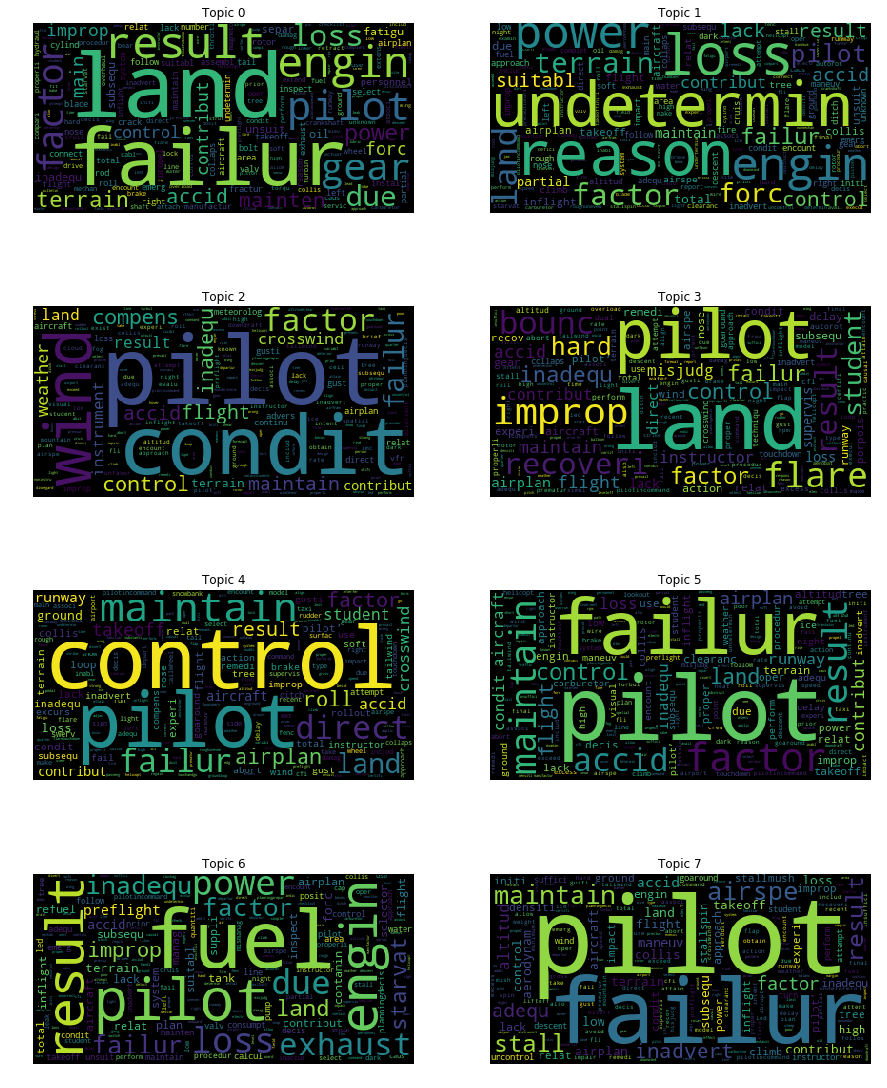

In [115]:
tfidf_topics = np.zeros((len(minikmeans_model.labels_), 8))
for i, j in zip(range(tfidf_topics.shape[0]), minikmeans_model.labels_):
    tfidf_topics[i, j] = 1
tfidf_topics
word_counter8 = [Counter(),Counter(),Counter(),Counter(),Counter(),Counter(),Counter(),Counter()]
plot_word_cloud(tfidf_topics, docs=docs_cause, word_counter=word_counter8, counting_method="max")

# Analysis of Event Labels

### Weather Condition and Event Cause

Might need to change topic index according to the topic result above because of the randomness on differnt platform.

In [74]:
def topic_weather(topic, df, model, plotting=True):
    '''
    return the count (proportion) of each WeatherCondition for given topic
    '''
    assert type(topic) == int
    
    temp = np.array(eventID_cause)
    event = temp[np.where(model.labels_ == topic)]
    df_topic = df[df["EventId"].isin(event)]
    c = Counter(df_topic["WeatherCondition"])
    IMC = c.get("IMC", 0)
    VMC = c.get("VMC", 0)
    UNK = c.get("UNK", 0)
    NA = c.get("", 0)
    cum_sum = IMC+VMC+UNK
    
    if plotting:
        x = ["IMC", "VMC", "UNK"]
        plt.bar(x, np.array([IMC,VMC,UNK])/cum_sum)
        plt.title("Weather Condition for Topic %d" % topic)
        plt.xlabel("Weather Condition")
        plt.show()
        
    return IMC, VMC, UNK, NA

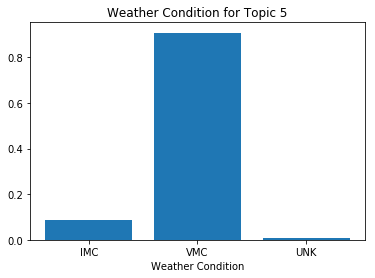

In [84]:
weather_topic5 = topic_weather(5, df_accident, minikmeans_model)

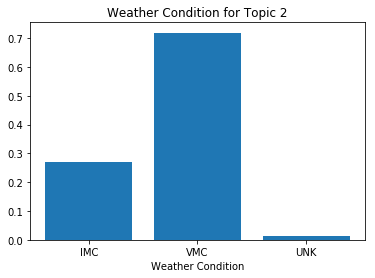

In [85]:
weather_topic2 = topic_weather(2, df_accident, minikmeans_model)

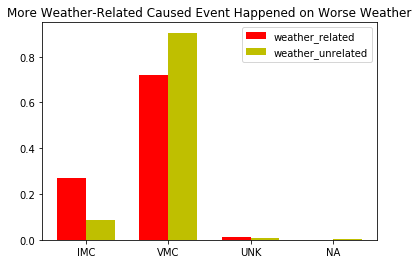

In [96]:
# side-by-side bar plot
ind = np.arange(4)
width = 0.35
weather_freq = weather_topic2 / np.sum(weather_topic2)
weather_un_freq = weather_topic5 / np.sum(weather_topic5)

fig, ax = plt.subplots()
weather = ax.bar(ind, weather_freq, width, color='r')
no_weather = ax.bar(ind + width, weather_un_freq, width, color='y')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('IMC', 'VMC', 'UNK', 'NA'))
ax.legend((weather[0], no_weather[0]), ('weather_related', 'weather_unrelated'))
ax.set_title("More Weather-Related Caused Event Happened on Worse Weather")
plt.show()

In [80]:
def weather_topic(condition, df, model, plotting=True):
    '''
    return the count (proportion) of each topic for a given WeatherCondition
    '''
    event = []
    portion = []
    cum_sum = 0
    df_weather = df[df['WeatherCondition'] == condition]
    for i in range(df_weather.shape[0]):
        if df_weather['EventId'][i] in eventID_cause:
            event.append(eventID_cause.index(df_weather['EventId'][i]))
    topic = model.predict(tfidf_cause_vec[event,:].reshape(len(event),4649))
    c = Counter(topic)
    for i in range(8):
        portion.append(c.get(i,0)/len(event))
        cum_sum += c.get(i,0)
    
    if plotting:
        x = [0,1,2,3,4,5,6,7]
        plt.bar(x, portion)
        plt.title('Topic Distribution under Weather of "%s"' % condition)
        plt.xlabel('Topic Number')
        plt.ylabel('Frequency')
        plt.show()
    
    return portion, cum_sum

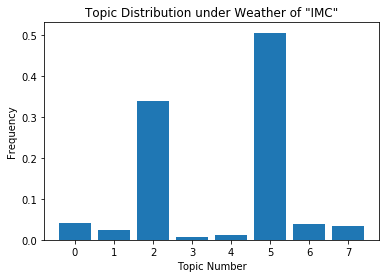

In [81]:
portion_IMC, cum_sum_IMC = weather_topic('IMC', df_accident, minikmeans_model)

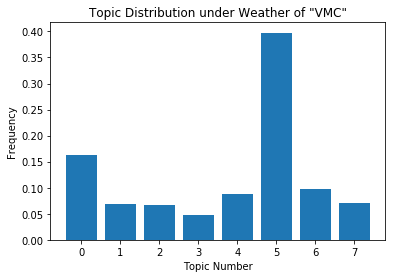

In [82]:
portion_VMC, cum_sum_VMC = weather_topic('VMC', df_accident, minikmeans_model)

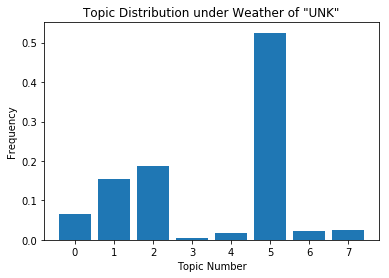

In [83]:
portion_UNK, cum_sum_UNK = weather_topic('UNK', df_accident, minikmeans_model)

We know that "IMC" stands for "Instrument Meteorological Conditions" and "VMC" stands for "Visual Meteorological Condition" and "UNK" stands for "Unknown". Thus, "IMC" means a worse weather condition (worse visibility) than "VMC". We found that the weather-related topics (topic 4 in this case) has a much larger frequncy of accident when weather conditon is "IMC".

### Fatal Rate and Event Cause

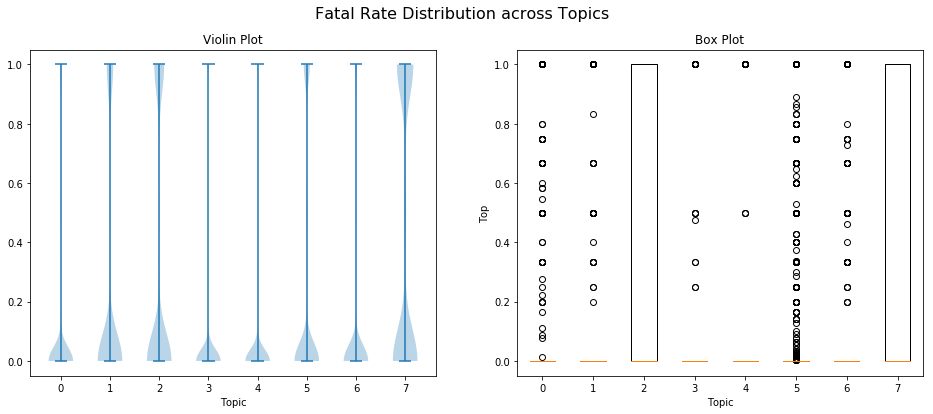

In [118]:
eventID_cause = np.array(eventID_cause)

def injure_topic(topic, df, model):
    event = eventID_cause[(model.labels_ == topic)]
    df_topic = df[df['EventId'].isin(event)]
    notnull = -df_topic["TotalFatalInjuries"].isin([""]) & -df_topic["TotalSeriousInjuries"].isin([""]) & -df_topic["TotalMinorInjuries"].isin([""]) & -df_topic["TotalUninjured"].isin([""])
    df_topic = df_topic[notnull]
    allzero = df_topic["TotalFatalInjuries"].isin(["0"]) & df_topic["TotalSeriousInjuries"].isin(["0"]) & df_topic["TotalMinorInjuries"].isin(["0"]) & df_topic["TotalUninjured"].isin(["0"])
    df_topic = df_topic[-allzero]
    fatal = np.array(df_topic['TotalFatalInjuries']).astype(int)
    total = np.array(df_topic['TotalFatalInjuries']).astype(int)+np.array(df_topic['TotalSeriousInjuries']).astype(int)+np.array(df_topic['TotalMinorInjuries']).astype(int)+np.array(df_topic['TotalUninjured']).astype(int)
    fatal_rate = fatal/total
    return fatal_rate

fatal_rate0 = injure_topic(0, df_accident, minikmeans_model)
fatal_rate1 = injure_topic(1, df_accident, minikmeans_model)
fatal_rate2 = injure_topic(2, df_accident, minikmeans_model)
fatal_rate3 = injure_topic(3, df_accident, minikmeans_model)
fatal_rate4 = injure_topic(4, df_accident, minikmeans_model)
fatal_rate5 = injure_topic(5, df_accident, minikmeans_model)
fatal_rate6 = injure_topic(6, df_accident, minikmeans_model)
fatal_rate7 = injure_topic(7, df_accident, minikmeans_model)
all = [fatal_rate0, fatal_rate1, fatal_rate2, fatal_rate3, fatal_rate4, fatal_rate5, fatal_rate6, fatal_rate7]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
fig.suptitle('Fatal Rate Distribution across Topics', fontsize = 16)
axes[0].violinplot(all)
axes[0].set_title('Violin Plot')
axes[0].set_xlabel('Topic')
axes[0].set_xlabel('Topic')

axes[1].boxplot(all)
axes[1].set_title('Box Plot')
axes[1].set_xlabel('Topic')
axes[1].set_ylabel('Top')

plt.setp(axes, xticks=[y + 1 for y in range(len(all))], xticklabels=['0', '1', '2', '3','4','5','6','7'])
plt.show()

In [133]:
fatal_rate_all = [fatal_rate0,fatal_rate1,fatal_rate2,fatal_rate3,fatal_rate4,fatal_rate5,fatal_rate6,fatal_rate7]
count_all = np.array(list(map(len, fatal_rate_all))).reshape(8,1)
median_all = np.array(list(map(np.median, fatal_rate_all))).reshape(8,1)
mean_all = np.array(list(map(np.mean, fatal_rate_all))).reshape(8,1)
max_all = np.array(list(map(np.max, fatal_rate_all))).reshape(8,1)
min_all = np.array(list(map(np.min, fatal_rate_all))).reshape(8,1)


df_cnt = pd.DataFrame(np.c_[count_all, median_all, mean_all, max_all, min_all],
                      columns = ['Observation Count', 'Meidan', 'Mean', 'Max', 'Min'])
df_cnt

Observation Count  Meidan      Mean  Max  Min
0             4239.0     0.0  0.068640  1.0  0.0
1             1710.0     0.0  0.212242  1.0  0.0
2             2628.0     0.0  0.291718  1.0  0.0
3             1041.0     0.0  0.027515  1.0  0.0
4             1759.0     0.0  0.030984  1.0  0.0
5            11563.0     0.0  0.210689  1.0  0.0
6             2721.0     0.0  0.077786  1.0  0.0
7             1785.0     0.0  0.406411  1.0  0.0

I join the event cause text data and event table data by selecting EventId with non-missing probale_cause text and non-missing injuries count. Then I plot the distribution of fatal rate for each topic. 

Due to the highly skewed distribuiton of fatal rate data ,all topics have 0.0 median, 0.0 min and 1.0 max for fatal rate. Topic 0, 3, 4 and 6 have relatively low fatal rate. Topic 1, 2 and 5 have medium fatal rate. Topic 7 has a large fatal rate. When looking at the key words for each topic, I find that topics with low fata rate are focusing on landing gear (Topic 0), bounce and flare (Topic 3), maintain direction (Topic 4) or exhausting fuel (Topic 6). Topics with mediu fatal rate are about weather condition like wind (Topic 2), pilot's failure for maintaining clearance (Topic 5) or undetermined reason (Topic 1). High fatal rate often result from failure of maintaining airspeed (Topic 7).

All these show that severe accidents (high fatal rate) often result from the damage of part of or whole airplane. This damage often comes from failure of maintaining airspeed, failure of maintaining clearance, etc. This often caused directly by pilots' inappropriate operation or negligence of environment. On the other hand, pilots are good at dealing with small or obvious damage, such as landing gear, fuel, flare and bounce. 

# Appendix

### LSI result

The weigt of topics could represent the true topic to some extent. However, LSI create highly correlated topics which is hard to analyze.

In [139]:
### LSI topic weight for random event
for i in np.random.randint(0, len(eventID_cause), 5):
    if lsi_cause[corpus_cause[i]] != []:
        pprint(lsi_cause[corpus_cause[i]])
        print(narr_dict[eventID_cause[i]]["probable_cause"])
        print("="*115)

[(0, 1.6543840706229778),
 (1, -2.9534848525923176),
 (2, 0.8891687473835868),
 (3, -0.8240914653284406),
 (4, -1.4808458768904573),
 (5, 0.40629398012457496),
 (6, 0.32668450367705987),
 (7, -0.6180210333979457),
 (8, -0.21925610368958393),
 (9, -0.0009675370424103799),
 (10, -0.25326255476117654),
 (11, 0.5813412560854165),
 (12, 0.05995937050040334),
 (13, -0.0010415749308136744),
 (14, -0.3607065739154981)]
A loss of power to both engines resulting from a fitting failure and leak at the right fuel selector valve that allowed fuel from the right tank to be lost overboard, and that then introduced air into the left engine's fuel lines during an attempted cross-feed operation.
[(0, 2.0087599200148136),
 (1, -1.0054098992878562),
 (2, -0.538626257651941),
 (3, -0.6825347489099229),
 (4, 0.9207633441646214),
 (5, 1.7381699893709486),
 (6, 0.22264172184238498),
 (7, -0.6842502555421408),
 (8, 0.021520896126708513),
 (9, -0.2350294725895012),
 (10, 0.3848738741559705),
 (11, 0.02092037101

### LDA result with differnt number of topics

It is hard to choose a universally optimal number of topics for LDA method. Differnt number of topics uncover differnt level of details hidden in the texts. 

When use 6 topics, 5 of them are mainly about pilot's failure. Only one of them is focused on airplane related failure (like "engine", "fuel" and "loss"). Even within the pilot's failure, however, differnt topics have diffent mini-focus such as "maintainance", "landing" and "clearance".

When use 10 or 16 topics, even more detial information were found, in addition to previous results. More causes were shown in wordcloud plots, including "takeoff", "touchdown", "airspeed", etc.. Also, "engine" and "fuel" were seperated into different causes, showing the subtle difference between them.

In [140]:
### Latent Dirichlet Allocation
# extract 6 LDA topics, using 1 pass and updating once every 1 chunk (10,000 documents)
lda_cause6 = ldamodel.LdaModel(corpus=corpus_cause, id2word=dict_cause, num_topics=6,
                               update_every=1, passes=1, random_state=323)

lda_cause6.show_topics()

[(0,
  '0.090*"pilot" + 0.067*"failur" + 0.067*"maintain" + 0.063*"control" + 0.036*"land" + 0.036*"factor" + 0.036*"direct" + 0.031*"result" + 0.024*"wind" + 0.023*"airplan"'),
 (1,
  '0.076*"pilot" + 0.038*"factor" + 0.038*"failur" + 0.035*"condit" + 0.033*"maintain" + 0.029*"flight" + 0.025*"terrain" + 0.024*"accid" + 0.022*"clearanc" + 0.019*"altitud"'),
 (2,
  '0.073*"pilot" + 0.061*"land" + 0.034*"failur" + 0.033*"result" + 0.031*"improp" + 0.023*"flight" + 0.020*"runway" + 0.019*"factor" + 0.019*"student" + 0.017*"flare"'),
 (3,
  '0.073*"engin" + 0.071*"power" + 0.069*"fuel" + 0.067*"loss" + 0.034*"result" + 0.032*"pilot" + 0.032*"due" + 0.031*"undetermin" + 0.031*"reason" + 0.030*"land"'),
 (4,
  '0.046*"failur" + 0.035*"gear" + 0.032*"land" + 0.026*"result" + 0.023*"mainten" + 0.021*"due" + 0.019*"engin" + 0.015*"main" + 0.013*"right" + 0.013*"system"'),
 (5,
  '0.026*"pilot" + 0.024*"failur" + 0.020*"takeoff" + 0.020*"airplan" + 0.015*"result" + 0.015*"accid" + 0.015*"high" 

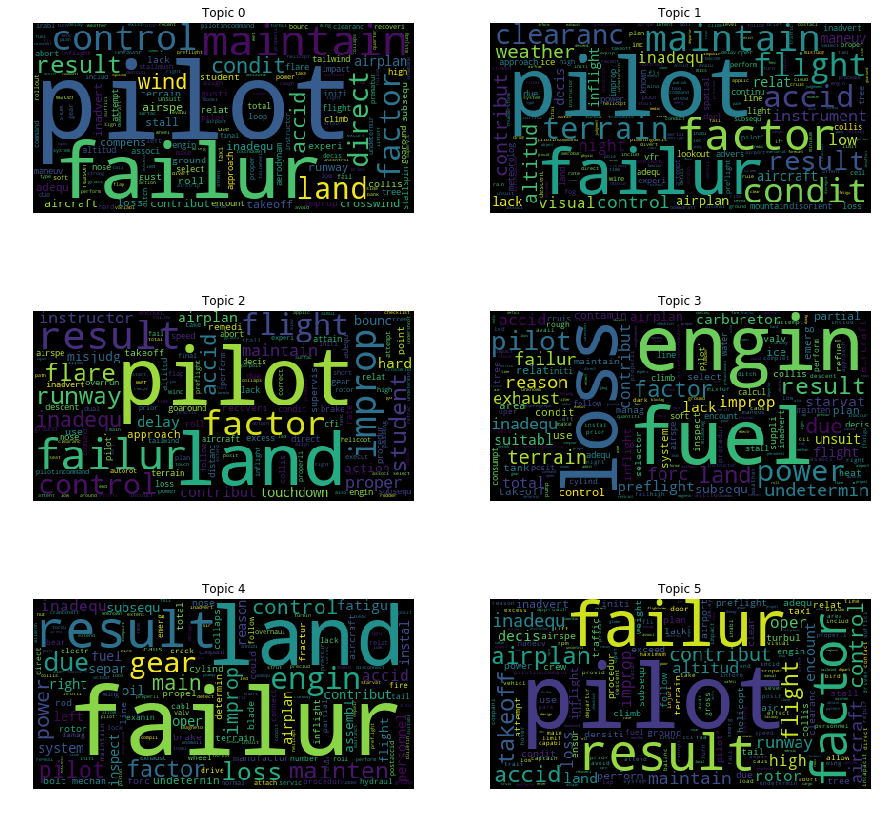

In [141]:
topic_weight_cause_lda6 = get_weights(method="lda", model=lda_cause6, corpus=corpus_cause)
word_counter6 = [Counter(),Counter(),Counter(),Counter(),Counter(),Counter()]

plot_word_cloud(topic_weight_cause_lda6, docs=docs_cause, word_counter=word_counter6, counting_method="max")

In [142]:
### Latent Dirichlet Allocation
# extract 10 LDA topics, using 1 pass and updating once every 1 chunk (10,000 documents)
lda_cause10 = ldamodel.LdaModel(corpus=corpus_cause, id2word=dict_cause, num_topics=10, 
                                update_every=1, passes=1, random_state=323)

lda_cause10.show_topics()

[(0,
  '0.080*"pilot" + 0.064*"failur" + 0.052*"maintain" + 0.044*"airspe" + 0.043*"result" + 0.036*"stall" + 0.029*"inadvert" + 0.027*"adequ" + 0.023*"airplan" + 0.020*"maneuv"'),
 (1,
  '0.074*"pilot" + 0.041*"failur" + 0.040*"condit" + 0.039*"maintain" + 0.037*"factor" + 0.033*"flight" + 0.029*"clearanc" + 0.027*"terrain" + 0.022*"accid" + 0.021*"weather"'),
 (2,
  '0.075*"pilot" + 0.067*"runway" + 0.045*"failur" + 0.038*"land" + 0.035*"factor" + 0.029*"proper" + 0.022*"takeoff" + 0.020*"result" + 0.020*"accid" + 0.018*"touchdown"'),
 (3,
  '0.114*"engin" + 0.108*"power" + 0.106*"loss" + 0.049*"reason" + 0.048*"undetermin" + 0.043*"fuel" + 0.041*"due" + 0.035*"result" + 0.033*"land" + 0.031*"forc"'),
 (4,
  '0.050*"failur" + 0.037*"gear" + 0.033*"land" + 0.029*"result" + 0.029*"mainten" + 0.024*"due" + 0.017*"system" + 0.017*"fuel" + 0.017*"main" + 0.017*"engin"'),
 (5,
  '0.058*"high" + 0.027*"densiti" + 0.027*"altitud" + 0.022*"factor" + 0.020*"flight" + 0.019*"contribut" + 0.018*

In [143]:
topic_weight_cause_lda10 = get_weights(method="lda", model=lda_cause10, corpus=corpus_cause)
word_counter10 = [Counter(),Counter(),Counter(),Counter(),Counter(),Counter(),Counter(),Counter(),Counter(),Counter()]

plot_word_cloud(topic_weight_cause_lda10, docs=docs_cause, word_counter=word_counter10, counting_method="avg")

In [144]:
### Latent Dirichlet Allocation
# extract 16 LDA topics, using 1 pass and updating once every 1 chunk (10,000 documents)
lda_cause16 = ldamodel.LdaModel(corpus=corpus_cause, id2word=dict_cause, num_topics=16, 
                                update_every=1, passes=1, random_state=323)

lda_cause16.show_topics()

[(2,
  '0.078*"pilot" + 0.067*"runway" + 0.062*"failur" + 0.042*"proper" + 0.034*"land" + 0.033*"factor" + 0.027*"takeoff" + 0.022*"touchdown" + 0.021*"approach" + 0.020*"result"'),
 (8,
  '0.130*"control" + 0.094*"pilot" + 0.093*"maintain" + 0.086*"failur" + 0.076*"direct" + 0.052*"land" + 0.034*"airplan" + 0.028*"factor" + 0.028*"crosswind" + 0.026*"roll"'),
 (11,
  '0.075*"pilot" + 0.062*"airspe" + 0.058*"failur" + 0.054*"maintain" + 0.054*"result" + 0.051*"stall" + 0.041*"inadvert" + 0.038*"wind" + 0.032*"adequ" + 0.027*"factor"'),
 (6,
  '0.070*"flight" + 0.050*"instructor" + 0.043*"student" + 0.036*"control" + 0.034*"failur" + 0.034*"action" + 0.033*"rotor" + 0.032*"inadequ" + 0.030*"pilot" + 0.029*"remedi"'),
 (0,
  '0.155*"fuel" + 0.052*"pilot" + 0.052*"engin" + 0.050*"result" + 0.044*"power" + 0.042*"loss" + 0.040*"due" + 0.037*"exhaust" + 0.034*"inadequ" + 0.027*"starvat"'),
 (13,
  '0.067*"brake" + 0.039*"pilot" + 0.035*"excess" + 0.033*"flap" + 0.031*"airplan" + 0.028*"appl

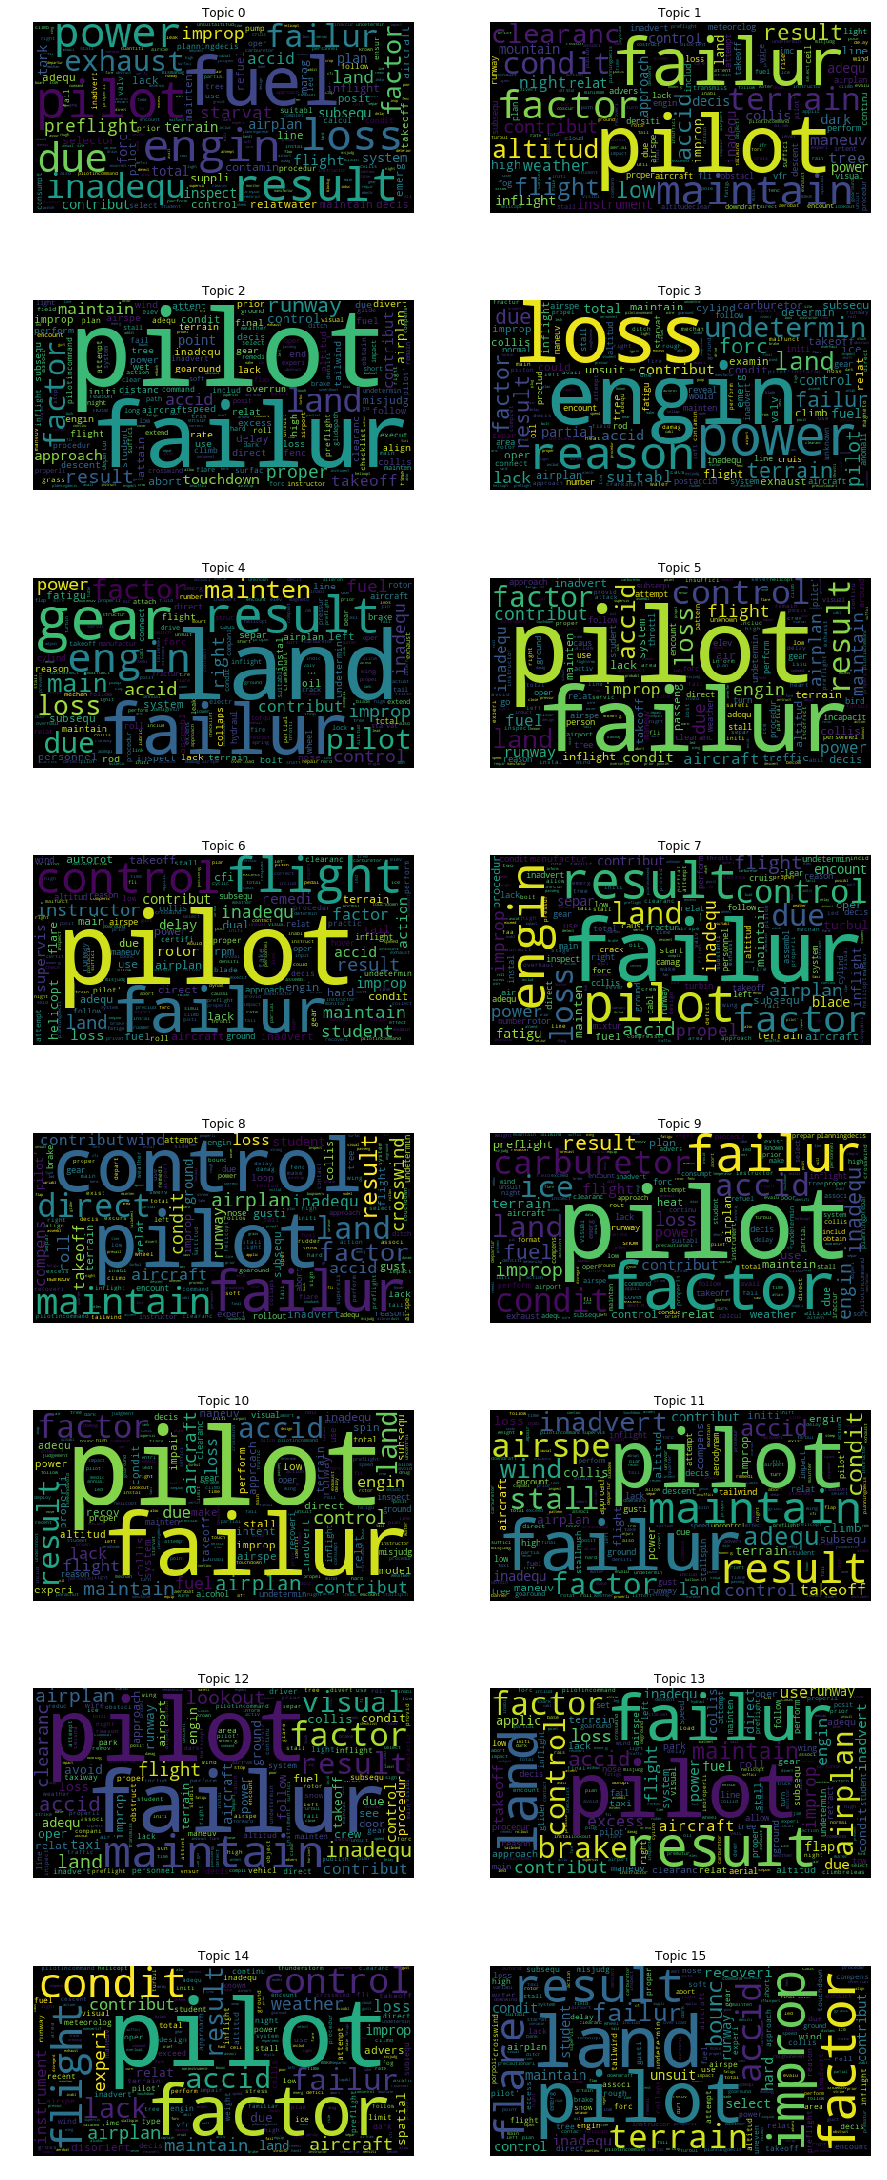

In [145]:
topic_weight_cause_lda16 = get_weights(method="lda", model=lda_cause16, corpus=corpus_cause)
word_counter16 = [Counter(),Counter(),Counter(),Counter(),Counter(),Counter(),Counter(),Counter(),Counter(),
                  Counter(),Counter(),Counter(),Counter(),Counter(),Counter(),Counter()]

plot_word_cloud(topic_weight_cause_lda16, docs=docs_cause, word_counter=word_counter16, counting_method="avg")

## Vectorizing Narrative Documents

Unlike "probable_cause", "narrative" contains more unstructured words and sentences. It's hard to generate useful insigts using the above methods. To take advantage of the narrative data, I tried to use doc2vec method to vectorize each document.

In [146]:
### preprocess both probable_cause and narrative text
docs_both, eventID_both, freq_both = preprocess(d = narr_dict, item="both")

# create dictionary between tokens and counts
dict_both = corpora.Dictionary(docs_both)

# create corpus for each document
corpus_both = [dict_both.doc2bow(doc) for doc in docs_both]

### doc2vec

In [147]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

docs_both_tag = [TaggedDocument(doc, [i]) for i, doc in enumerate(docs_both)]
# unable to set seed with multiple workers
d2v_both = Doc2Vec(documents=docs_both_tag, vector_size=128, window=5, min_count=2, workers=4, )

In [148]:
from sklearn.cluster import KMeans

docvec_both = np.array([d2v_both.docvecs[i] for i in range(d2v_both.docvecs.count)])
kmeans_both = KMeans(n_clusters=8, random_state=323).fit(docvec_both)

In [149]:
for i in range(8):
    most_sim = d2v_both.wv.most_similar(positive=[kmeans_both.cluster_centers_[i]], topn=10)
    pprint(most_sim)
    print("="*60)

[('hampshiregu', 0.9244558215141296),
 ('roadaldershot', 0.9213152527809143),
 ('airporttel', 0.9175622463226318),
 ('faasa', 0.9170475006103516),
 ('guangzho', 0.9161617159843445),
 ('arriaga', 0.9136841297149658),
 ('triamteren', 0.9082351922988892),
 ('oe', 0.907794713973999),
 ('empresa', 0.9039945006370544),
 ('gcm', 0.902679443359375)]
[('bkb', 0.93387371301651),
 ('thf', 0.9295138716697693),
 ('airwest', 0.9137469530105591),
 ('agustawestland', 0.9084852933883667),
 ('beluru', 0.9084520936012268),
 ('arrg', 0.9058860540390015),
 ('early”', 0.9053066968917847),
 ('aeromast', 0.9012578129768372),
 ('nkb', 0.9005314707756042),
 ('denham', 0.8996353149414062)]
[('gol', 0.9789356589317322),
 ('bluegray', 0.9783769845962524),
 ('mmgl', 0.9762672185897827),
 ('powerseri', 0.9747152328491211),
 ('bartlesvil', 0.973928689956665),
 ('rimemix', 0.9704917669296265),
 ('piac', 0.9677685499191284),
 ('twentyon', 0.9676426649093628),
 ('highstresslowcycl', 0.967516303062439),
 ('oe', 0.9673383

In [150]:
for i in range(8):
    most_sim = d2v_both.wv.most_similar(positive=[kmeans_both.cluster_centers_[i]], topn=1000)
    printed = []
    for j in most_sim:
        if freq_both[j[0]] >= 10:
            temp = j + ("freq:",freq_both[j[0]])
            printed.append(temp)
    pprint(printed)
    print("="*60)

[('pma', 0.8652012944221497, 'freq:', 10),
 ('sonex', 0.8396787643432617, 'freq:', 10),
 ('msb', 0.8373644351959229, 'freq:', 15),
 ('aviación', 0.8305631279945374, 'freq:', 12),
 ('croatia', 0.8250611424446106, 'freq:', 10),
 ('uppermost', 0.8233641982078552, 'freq:', 11),
 ('telescop', 0.8178735375404358, 'freq:', 18),
 ('bahrain', 0.81705242395401, 'freq:', 10),
 ('lw', 0.8169398307800293, 'freq:', 15),
 ('—', 0.8160747289657593, 'freq:', 12),
 ('cylinder’', 0.8159207105636597, 'freq:', 20),
 ('inth', 0.8130173683166504, 'freq:', 12),
 ('coloc', 0.8097108602523804, 'freq:', 13),
 ('jtsb', 0.8096774816513062, 'freq:', 21),
 ('scheme', 0.8075496554374695, 'freq:', 12),
 ('inchpound', 0.8072144389152527, 'freq:', 22),
 ('fatigueth', 0.8061153888702393, 'freq:', 11),
 ('sshape', 0.8046427965164185, 'freq:', 12)]
[('nsh', 0.8945698142051697, 'freq:', 10),
 ('hh', 0.8568400144577026, 'freq:', 16),
 ('uhb', 0.8549582958221436, 'freq:', 12),
 ('aviación', 0.8215341567993164, 'freq:', 12),
 

I used the generative vectors to train a KMeans algorithm with 8 clusters. Then I compute the most similar word to the center of each cluster. The results of that are hard to interpret and hard to use, because the dataset is relatively small for training a good doc2vec model. Most similar words would be unfrequent words if not filtering them out. 

However, I used 2 models here to reach this results. I did not spend tons of time testing differnt hyperparameters on these two models because there are numerous possible combinations. This might be another possible reason for not making a great result.